steps to follow
1. pip install selenium
2. install selenium chrome driver https://chromedriver.chromium.org/downloads (check your crome version)
3. specify driver path
4. pip install pillow


In [1]:
!pip install selenium

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
!pip install pillow

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [6]:
import selenium
from selenium import webdriver
import io
import PIL
import hashlib
from io import StringIO
from PIL import Image
# This is the path I use
# DRIVER_PATH = '.../Desktop/Scraping/chromedriver 2'
# Put the path for your ChromeDriver here
DRIVER_PATH = 'chromedriver.exe'
wd = webdriver.Chrome(executable_path=DRIVER_PATH)
wd.get('https://google.com')
search_box = wd.find_element_by_css_selector('input.gLFyf')
search_box.send_keys('Dogs')

In [7]:
wd.quit()

In [8]:
def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception:
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

In [9]:
def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
        print(f"SUCCESS - saved {url} - as {file_path}")
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

In [25]:
def search_and_download(search_term:str,driver_path:str,number_images:int,folder_name,target_path='./images'):
    target_folder = os.path.join(target_path,folder_name)

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5)
        
    for elem in res:
        persist_image(target_folder,elem)

In [26]:
import os
import time
import requests

Found: 100 search results. Extracting links from 0:100
Found: 31 image links, done!
SUCCESS - saved https://images-na.ssl-images-amazon.com/images/I/71FemG7%2BWtL._AC_UL1500_.jpg - as ./images\mask\a0a7233826.jpg
SUCCESS - saved https://www.nationalgeographic.com/content/dam/science/2020/09/11/face-mask-recognition/20200901_002_out_mp4_00_00_03_18_still003.jpg - as ./images\mask\0fd78281d0.jpg
SUCCESS - saved https://bluebiz-media.azureedge.net/49aec8/contentassets/01968db1934642ceb2a49e013ac25e61/facemask_624.jpg - as ./images\mask\6ed1caf851.jpg
SUCCESS - saved https://static.dezeen.com/uploads/2020/08/burberry-face-masks-coronavirus-pandemic-fashion-design-ppe_dezeen_2364_sq.jpg - as ./images\mask\b61fe483cc.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRO4GbalcSYICl8aTv8L8AAFk_0XPNHE-NmDA&usqp=CAU - as ./images\mask\de4b495435.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ-M0cU0B3xX8tkjuMcDLc-lq0N1cacvWt-Ng&usqp=CAU - as ./im

SUCCESS - saved https://images-na.ssl-images-amazon.com/images/I/61%2BMR8FXzsL._AC_SY355_.jpg - as ./images\mask\f44194a424.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQKJZclaXhdsoplG4P-TaYff4Z8hpvfJCptTQ&usqp=CAU - as ./images\mask\b1bbe51eae.jpg
SUCCESS - saved https://image.freepik.com/free-vector/asian-woman-wearing-disposable-medical-surgical-face-mask-protect-against-high-air-toxic-pollution-city_77430-281.jpg - as ./images\mask\12ad118c97.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQkedpzdvkgVsRM_-cv4ZqZyWCbSKxCWgvsaQ&usqp=CAU - as ./images\mask\68282b196f.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ71zP-OuB2jYMs-VCS6jihz6Ueb4jANgWunQ&usqp=CAU - as ./images\mask\87fe935790.jpg
SUCCESS - saved https://www.bupa.co.uk/~/media/Images/HealthManagement/Blogs/700-350/2020/woman-face-mask-700-350.jpg - as ./images\mask\b02e2d27c3.jpg
SUCCESS - saved https://images1.westend61.de/0001473167pw/senior

SUCCESS - saved https://media.gettyimages.com/photos/young-woman-wearing-face-mask-using-smartphone-at-subway-station-picture-id1218141991 - as ./images\mask\ab8055cae8.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKGS66vR2dkepc9uwkLlbjDGlyiKvfZ6TkpA&usqp=CAU - as ./images\mask\d66d503222.jpg
SUCCESS - saved https://images.westend61.de/0001461657pw/young-woman-wearing-face-mask-using-mobile-phone-while-standing-in-city-KIJF03306.jpg - as ./images\mask\116e4c525c.jpg
SUCCESS - saved https://media.allure.com/photos/5e34ab188a385400093f2a16/16:9/w_2560%2Cc_limit/mask.jpg - as ./images\mask\8a3afcfcd4.jpg
SUCCESS - saved https://images.westend61.de/0001474113pw/women-wearing-face-mask-talking-while-walking-in-city-MPPF01249.jpg - as ./images\mask\57c07b26aa.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTzMRCi-AlxLUk2z9oXHKpmgbMRqnhhrxWZ5A&usqp=CAU - as ./images\mask\3b332fde7d.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/im

SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQuYH115Hjr3MkpV73yFMV9cQ9ikvTdFru_6A&usqp=CAU - as ./images\mask\a7c1b89c71.jpg
SUCCESS - saved https://ichef.bbci.co.uk/news/1024/cpsprodpb/12003/production/_113613737_comp_faces.jpg - as ./images\mask\bf0762dabb.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSQZ4ZMkbygvWek4BjRSgRng_s4beFMCPzMcA&usqp=CAU - as ./images\mask\0883ef9ac4.jpg
SUCCESS - saved https://www.pennmedicine.org/-/media/images/miscellaneous/smiles/woman_green_beauty_mask2.ashx?mw=620&mh=408 - as ./images\mask\07c77e851a.jpg
SUCCESS - saved https://i.guim.co.uk/img/media/6b887b1b3b5bdec0921e4ef28ade834e2327e2f7/0_0_2500_1500/master/2500.jpg?width=1200&quality=85&auto=format&fit=max&s=ac518a23c15f5e2e8ca1f28e40727c25 - as ./images\mask\ae2d6fbec1.jpg
SUCCESS - saved https://im-media.voltron.voanews.com/Drupal/01live-166/styles/sourced/s3/2020-04/reuters_poland_rainbow_face_maks_23Apr20.JPG?itok=LtKJU_z_ - as ./images\mask

SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQafPebe1GZTmHD6VCSjn1H3Bdxl6jPsfLp2w&usqp=CAU - as ./images\mask\759eba69b3.jpg
SUCCESS - saved https://images.theconversation.com/files/353655/original/file-20200819-25336-1r3mhc4.jpg?ixlib=rb-1.1.0&rect=0%2C226%2C3680%2C2760&q=45&auto=format&w=496&fit=clip - as ./images\mask\b42052a61b.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQCt17nEzesIBJqJKeJKp8vKAttrxwtAlf_Vg&usqp=CAU - as ./images\mask\2ded4050de.jpg
Found: 100 search results. Extracting links from 0:100
Found: 71 image links, done!
SUCCESS - saved https://www.uni-regensburg.de/Fakultaeten/phil_Fak_II/Psychologie/Psy_II/beautycheck/english/prototypen/w_sexy_gr.jpg - as ./images\no_mask\c63a661327.jpg
SUCCESS - saved https://cdn.pocket-lint.com/r/s/1200x/assets/images/142207-phones-feature-what-is-apple-face-id-and-how-does-it-work-image1-5d72kjh6lq.jpg - as ./images\no_mask\fc9667f985.jpg
SUCCESS - saved https://encrypted-tbn0.g

SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTOb-Egr9gZ2SAg2IH6WCQv_GuARbmoF4eWBQ&usqp=CAU - as ./images\no_mask\d273e42c11.jpg
SUCCESS - saved https://upload.wikimedia.org/wikipedia/commons/a/a0/%D7%94%D7%9C%D7%95%D7%92%D7%95_%D7%A9%D7%9C_%D7%9E%D7%A2%D7%A8%D7%9B%D7%AA_%D7%94%D6%BEFace_ID.jpg - as ./images\no_mask\fce60b76b5.jpg
SUCCESS - saved https://cdn.shopify.com/s/files/1/0283/2973/8293/products/face-pro_b4b300f7-ac33-4102-accd-30f565bb0859_600x.jpg?v=1600379523 - as ./images\no_mask\50a8826a68.jpg
ERROR - Could not download https://dictionary.cambridge.org/es/images/thumb/face_noun_002_13169.jpg?version=5.0.115 - ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
ERROR - Could not save https://dictionary.cambridge.org/es/images/thumb/face_noun_002_13169.jpg?version=5.0.115 - local variable 'image_content' referenced before assignment
SUCCESS - saved https://i.pinimg.com/originals/97/e4/2a/97e42a82fc7911961d3ca55

SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTLaAngZUFSB89lzE4xSnnuvWGqJQ502Rigng&usqp=CAU - as ./images\no_mask\6dc1dbaa3f.jpg
SUCCESS - saved https://st3.depositphotos.com/13913926/18216/i/1600/depositphotos_182169322-stock-photo-beauty-woman-portrait-front-view.jpg - as ./images\no_mask\7130e8a48b.jpg
SUCCESS - saved https://cdna.artstation.com/p/assets/images/images/017/700/974/large/jessica-cho-001-jeshiki.jpg?1557017070 - as ./images\no_mask\3890ced63b.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSPlkudHAYGzvhT6_jC_bIOngaAXCFkZAShTg&usqp=CAU - as ./images\no_mask\10dc2a4396.jpg
ERROR - Could not download  - No connection adapters were found for ''
ERROR - Could not save  - local variable 'image_content' referenced before assignment

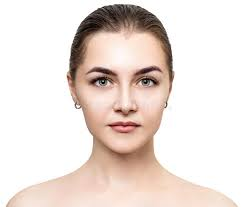
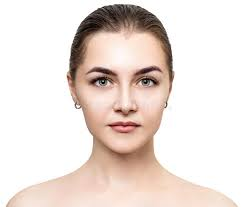
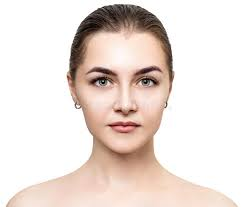

SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcThxtGmvN7KRbw2j0ZER8RNKf5aYyv9OBSzQQ&usqp=CAU - as ./images\no_mask\c4a4c4e694.jpg
SUCCESS - saved https://thumbs.dreamstime.com/b/front-view-beautiful-female-face-perfect-skin-front-view-beautiful-female-face-perfect-skin-over-white-background-143563838.jpg - as ./images\no_mask\0eb44a73de.jpg
SUCCESS - saved https://i.pinimg.com/originals/60/02/40/60024004696e3c679b264a391b40f41f.jpg - as ./images\no_mask\450a3af465.jpg
SUCCESS - saved https://image.shutterstock.com/image-photo/beauty-woman-face-portrait-beautiful-260nw-560474257.jpg - as ./images\no_mask\1fecfd88f6.jpg
SUCCESS - saved https://previews.123rf.com/images/seprimoris/seprimoris1101/seprimoris110100050/9305250-front-view-pure-face-of-woman-which-wearing-natural-make-up.jpg - as ./images\no_mask\a7359e307b.jpg
SUCCESS - saved https://as2.ftcdn.net/jpg/01/27/53/27/500_F_127532770_EJMUCRcHyRlbkiJ85OY5nRFHlKn3jJSo.jpg - as ./images\no_mask\2034cf3e44.jpg
SU

SUCCESS - saved https://media.istockphoto.com/photos/portrait-of-young-man-looking-at-camera-with-blank-expression-picture-id1086705960?k=6&m=1086705960&s=612x612&w=0&h=0GATmmJ6dQh6K9ILane5afOM0tXuuCrAw__loEuqMP8= - as ./images\no_mask\a4d0378acb.jpg
SUCCESS - saved https://st3.depositphotos.com/1653284/17461/i/1600/depositphotos_174617736-stock-photo-portrait-man-background-face-white.jpg - as ./images\no_mask\d2d8a7fcf6.jpg
SUCCESS - saved https://image.shutterstock.com/image-photo/young-man-smiling-portrait-260nw-219644644.jpg - as ./images\no_mask\45f5770ad9.jpg
SUCCESS - saved https://p0.piqsels.com/preview/896/975/817/man-holding-his-facial-hair.jpg - as ./images\no_mask\010bf74cc4.jpg
SUCCESS - saved https://image.shutterstock.com/image-photo/handsome-young-mans-face-portrait-260nw-211381648.jpg - as ./images\no_mask\d8a062e1a1.jpg
SUCCESS - saved https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT2L9qddQKGpIQVpCH60xv8Rk7GyUB9SPCWdg&usqp=CAU - as ./images\no_mask\7b8d256474.

In [27]:
search_terms_nomask = ['face images','model face front view','front view of face women','front view of face men']
no_of_images_nomask = [70,40,25,30]
search_terms_mask = ['face with mask','face mask woman','man wearing mask','woman wearing face mask','face with masks on']
no_of_images_mask = [30,40,25,50,60]
for i, j in zip(search_terms_mask,no_of_images_mask):
    search_and_download(search_term= i, driver_path=DRIVER_PATH, number_images=j,folder_name='mask')
for i, j in zip(search_terms_nomask,no_of_images_nomask):
    search_and_download(search_term= i, driver_path=DRIVER_PATH, number_images=j,folder_name='no_mask')